In [1]:
# Importe as bibliotecas que eu usei para treinar o autoencoder e avaliar as representações
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("TensorFlow:", tf.__version__)
print("Keras (tf.keras):", keras.__version__)

TensorFlow: 2.19.0
Keras (tf.keras): 3.10.0


In [2]:
# Fixei seeds para eu deixar os resultados mais reprodutíveis
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Carreguei o MNIST pelo Keras.

mnist_dir = Path(r"/content/MNIST")

def read_idx_images(path: Path) -> np.ndarray:
    with open(path, "rb") as f:
        magic = int.from_bytes(f.read(4), "big")
        if magic != 2051:
            raise ValueError(f"Arquivo inválido (magic={magic}) em {path.name}. Esperado 2051.")
        n_images = int.from_bytes(f.read(4), "big")
        n_rows   = int.from_bytes(f.read(4), "big")
        n_cols   = int.from_bytes(f.read(4), "big")
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(n_images, n_rows, n_cols)

def read_idx_labels(path: Path) -> np.ndarray:
    with open(path, "rb") as f:
        magic = int.from_bytes(f.read(4), "big")
        if magic != 2049:
            raise ValueError(f"Arquivo inválido (magic={magic}) em {path.name}. Esperado 2049.")
        n_labels = int.from_bytes(f.read(4), "big")
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(n_labels)

def carregar_mnist_robusto(mnist_dir: Path):
    try:
        (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
        origem = "keras.datasets.mnist"
    except Exception as e:
        print("Não consegui carregar pelo Keras, então eu usei o MNIST local.")
        print("Erro:", repr(e))

        x_train = read_idx_images(mnist_dir / "train-images.idx3-ubyte")
        y_train = read_idx_labels(mnist_dir / "train-labels.idx1-ubyte")
        x_test  = read_idx_images(mnist_dir / "t10k-images.idx3-ubyte")
        y_test  = read_idx_labels(mnist_dir / "t10k-labels.idx1-ubyte")
        origem = f"local IDX em {mnist_dir}"

    return (x_train, y_train), (x_test, y_test), origem

(x_train, y_train), (x_test, y_test), origem = carregar_mnist_robusto(mnist_dir)

print("Origem:", origem)
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test: ", x_test.shape,  "y_test: ", y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Origem: keras.datasets.mnist
x_train: (60000, 28, 28) y_train: (60000,)
x_test:  (10000, 28, 28) y_test:  (10000,)


In [4]:
# Normalizei os pixels para [0, 1] e achatei 28x28 -> 784
x_train_norm = x_train.astype("float32") / 255.0
x_test_norm  = x_test.astype("float32") / 255.0

x_train_flat = x_train_norm.reshape(len(x_train_norm), -1)
x_test_flat  = x_test_norm.reshape(len(x_test_norm), -1)

print("x_train_flat:", x_train_flat.shape)
print("x_test_flat: ", x_test_flat.shape)

x_train_flat: (60000, 784)
x_test_flat:  (10000, 784)


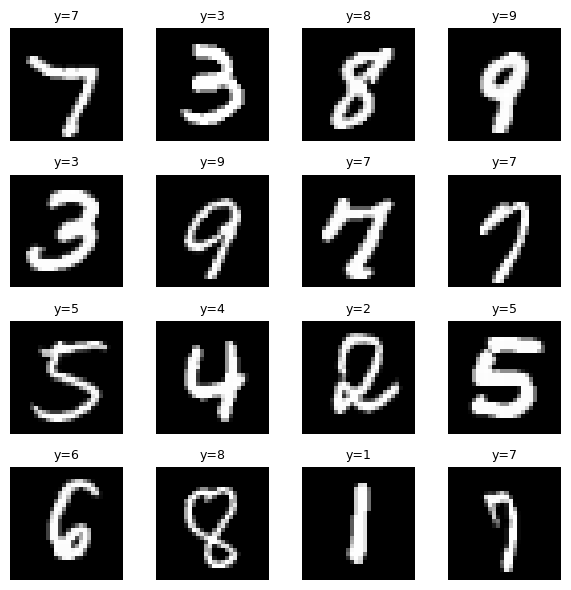

In [5]:
# Visualizei algumas imagens para eu confirmar que carreguei e normalizei corretamente
idx = np.random.choice(len(x_train), 16, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for ax, i in zip(axes.ravel(), idx):
    ax.imshow(x_train[i], cmap="gray")
    ax.set_title(f"y={y_train[i]}", fontsize=9)
    ax.axis("off")
plt.tight_layout()
plt.show()

In [6]:
# Implementei um autoencoder simples (MLP) trabalhando com o vetor 784:
# - Encoder: 784 -> 256 -> 64 (representação/embedding)
# - Decoder: 64 -> 256 -> 784

input_dim = 784
latent_dim = 64

inp = keras.Input(shape=(input_dim,), name="entrada")

x = layers.Dense(256, activation="relu")(inp)
z = layers.Dense(latent_dim, activation="relu", name="embedding")(x)

x = layers.Dense(256, activation="relu")(z)
out = layers.Dense(input_dim, activation="sigmoid", name="reconstrucao")(x)

autoencoder = keras.Model(inp, out, name="autoencoder_mlp")
encoder = keras.Model(inp, z, name="encoder_mlp")

autoencoder.summary()

Model: "autoencoder_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ entrada (InputLayer)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstrucao (Dense)            │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435,536 (1.66 MB)

 Trainable params: 435,536 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compilei e treinei o autoencoder em modo auto-supervisionado:
# eu usei o próprio X como target (reconstrução)

autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy"
)

early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = autoencoder.fit(
    x_train_flat, x_train_flat,
    validation_split=0.1,
    epochs=20,
    batch_size=256,
    callbacks=[early],
    verbose=1
)

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.3056 - val_loss: 0.1308
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1213 - val_loss: 0.1034
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1007 - val_loss: 0.0948
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0930 - val_loss: 0.0899
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0886 - val_loss: 0.0869
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0857 - val_loss: 0.0847
Epoch 7/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0835 - val_loss: 0.0831
Epoch 8/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0820 - val_loss: 0.0819
Epoch 9/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0807 - val_loss: 0.0808
Epoch 10/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0796 - val_loss: 0.0798
Epoch 11/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0788 - val_loss: 0.0798
Epoch 12/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

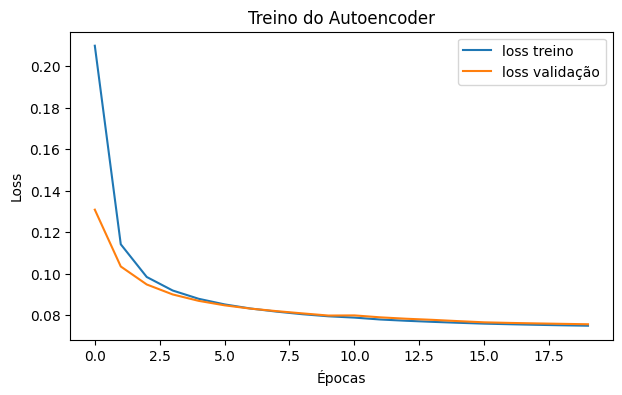

In [8]:
# Visualizei a curva de loss para eu checar se o modelo aprendeu a reconstruir
plt.figure(figsize=(7,4))
plt.plot(history.history["loss"], label="loss treino")
plt.plot(history.history["val_loss"], label="loss validação")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Treino do Autoencoder")
plt.legend()
plt.show()

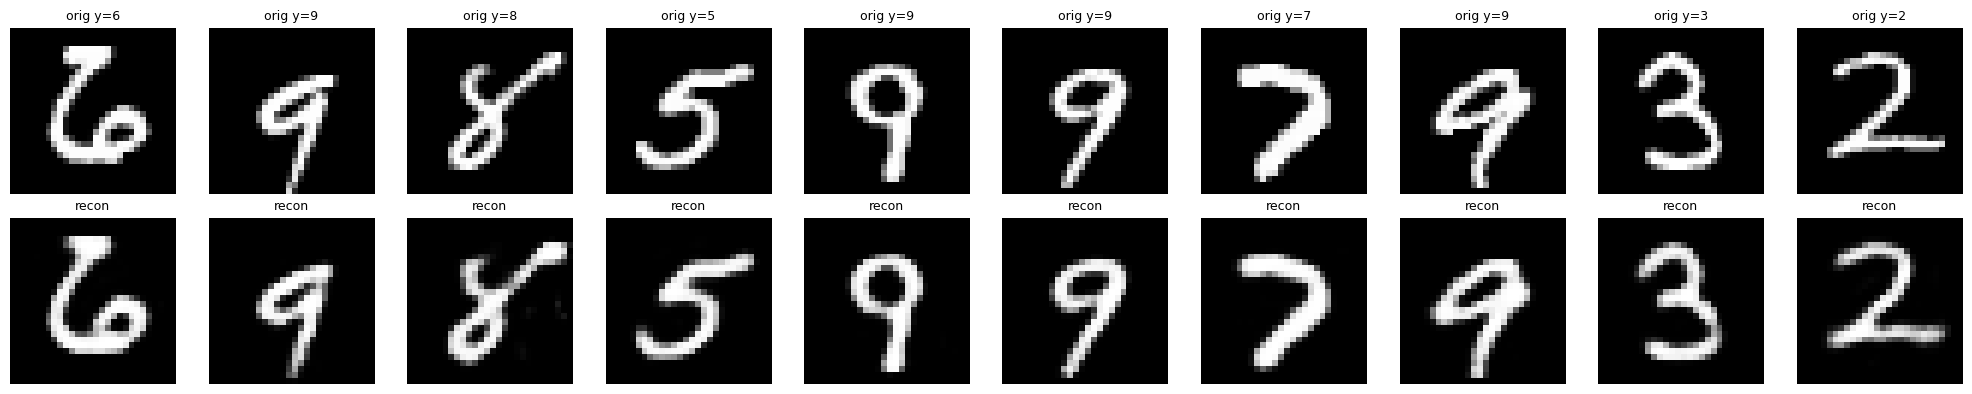

In [9]:
# Avaliei visualmente a qualidade da reconstrução comparando imagens originais e reconstruídas
n = 10
idx = np.random.choice(len(x_test_flat), n, replace=False)

recon = autoencoder.predict(x_test_flat[idx], verbose=0)

fig, axes = plt.subplots(2, n, figsize=(2*n, 4))

for j in range(n):
    axes[0, j].imshow(x_test_flat[idx[j]].reshape(28, 28), cmap="gray")
    axes[0, j].set_title(f"orig y={y_test[idx[j]]}", fontsize=9)
    axes[0, j].axis("off")

    axes[1, j].imshow(recon[j].reshape(28, 28), cmap="gray")
    axes[1, j].set_title("recon", fontsize=9)
    axes[1, j].axis("off")

plt.tight_layout()
plt.show()

Embeddings treino: (60000, 64)
Embeddings teste:  (10000, 64)


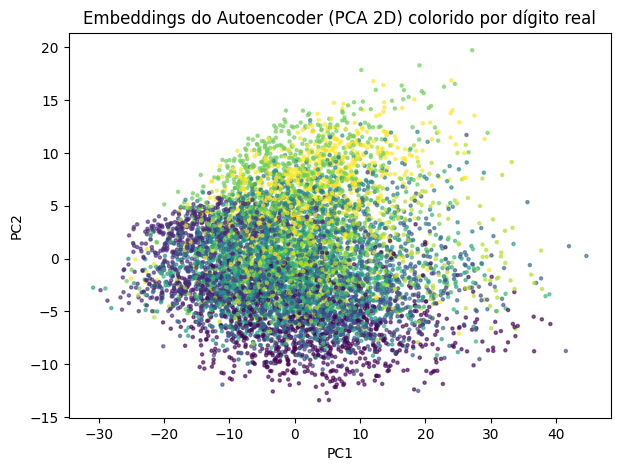

In [10]:
# Extraí as representações do encoder (embeddings) e projetei em 2D com PCA para visualizar separação

emb_train = encoder.predict(x_train_flat, verbose=0)
emb_test  = encoder.predict(x_test_flat, verbose=0)

print("Embeddings treino:", emb_train.shape)
print("Embeddings teste: ", emb_test.shape)

pca2 = PCA(n_components=2, random_state=42)
emb_test_2d = pca2.fit_transform(emb_test)

# Plotei uma amostra para não ficar pesado
rng = np.random.default_rng(42)
sidx = rng.choice(len(emb_test_2d), size=8000, replace=False)

plt.figure(figsize=(7,5))
plt.scatter(emb_test_2d[sidx, 0], emb_test_2d[sidx, 1], s=5, alpha=0.6, c=y_test[sidx])
plt.title("Embeddings do Autoencoder (PCA 2D) colorido por dígito real")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [11]:
# Usei os embeddings (sem rótulos) em uma tarefa simples de clusterização (K-Means)
# Depois eu comparei com os targets reais só para avaliar o quanto separou

def majority_mapping_accuracy(y_true: np.ndarray, cluster_labels: np.ndarray):
    mapping = {}
    y_pred = np.zeros_like(y_true)
    for c in np.unique(cluster_labels):
        mask = (cluster_labels == c)
        majority = np.bincount(y_true[mask]).argmax()
        mapping[int(c)] = int(majority)
        y_pred[mask] = majority
    acc = (y_pred == y_true).mean()
    return float(acc), mapping

k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(emb_test)

sil = silhouette_score(emb_test, clusters, sample_size=10000, random_state=42)
ari = adjusted_rand_score(y_test, clusters)
nmi = normalized_mutual_info_score(y_test, clusters)
acc, mapping = majority_mapping_accuracy(y_test, clusters)

print("Eu avaliei K-Means nos embeddings:")
print(f"Silhouette: {sil:.4f}")
print(f"ARI:        {ari:.4f}")
print(f"NMI:        {nmi:.4f}")
print(f"Purity/Acc: {acc:.4f}")
print("Mapeamento (cluster -> dígito por maioria):", mapping)

Eu avaliei K-Means nos embeddings:
Silhouette: 0.0718
ARI:        0.2231
NMI:        0.3712
Purity/Acc: 0.4410
Mapeamento (cluster -> dígito por maioria): {0: 1, 1: 0, 2: 3, 3: 3, 4: 9, 5: 2, 6: 4, 7: 6, 8: 1, 9: 0}


In [12]:
# Comparei duas abordagens com poucos rótulos (10%):
# A) LogisticRegression direto nos pixels (784)
# B) LogisticRegression nos embeddings (64) -> normalmente fica mais fácil classificar

# Criei um cenário com poucos rótulos no treino
Xtr, Xval, ytr, yval = train_test_split(x_train_flat, y_train, test_size=0.9, stratify=y_train, random_state=42)

# A) pixels
clf_pixels = LogisticRegression(max_iter=2000, n_jobs=-1)
clf_pixels.fit(Xtr, ytr)
pred_pix = clf_pixels.predict(x_test_flat)

acc_pix = accuracy_score(y_test, pred_pix)
f1_pix = f1_score(y_test, pred_pix, average="macro")

print("Eu avaliei classificação com poucos rótulos usando PIXELS:")
print(f"Accuracy: {acc_pix:.4f}")
print(f"F1-macro: {f1_pix:.4f}")

# B) embeddings
Emb_tr = encoder.predict(Xtr, verbose=0)
Emb_te = emb_test  # já extraído acima

clf_emb = LogisticRegression(max_iter=2000, n_jobs=-1)
clf_emb.fit(Emb_tr, ytr)
pred_emb = clf_emb.predict(Emb_te)

acc_emb = accuracy_score(y_test, pred_emb)
f1_emb = f1_score(y_test, pred_emb, average="macro")

print("\nEu avaliei classificação com poucos rótulos usando EMBEDDINGS do autoencoder:")
print(f"Accuracy: {acc_emb:.4f}")
print(f"F1-macro: {f1_emb:.4f}")

Eu avaliei classificação com poucos rótulos usando PIXELS:
Accuracy: 0.8983
F1-macro: 0.8967

Eu avaliei classificação com poucos rótulos usando EMBEDDINGS do autoencoder:
Accuracy: 0.9045
F1-macro: 0.9031
